In [1]:
import numpy as np
import scipy.io
from scipy.ndimage import gaussian_filter1d
import ot
import ot.plot
from pathlib import Path
import functions as fs
from sklearn.manifold import MDS
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [41]:
# %% PARAMETERS
animal = 3
session = '1Square'
smooth_position = True
sigma_pos = 2
ratemap_bins = 25
sigma_ratemaps = 1.5

filter_rate = True
firingh_th_high = 10 # in Hz
firing_th_low = 0.1

output_folder = 'processed_data'


In [42]:
# import session A
path = f'../SleepData_Matteo/Open_field/AH{animal}/{session}'
mat = scipy.io.loadmat(path+'/spike_times.mat')
spike_times = mat['spike_times'][0]
spike_times = [i.flatten() for i in spike_times]

mat = scipy.io.loadmat(path+'/trajectorypos.mat')
position = mat['trajectorypos']

mat = scipy.io.loadmat(path+'/framesnewtraj2.mat')
recording_mask = mat['framesnewtraj2'][0]

mat = scipy.io.loadmat(path+'/pos_times.mat')
pos_times = mat['pos_times'][0]



# %% SMOOTH AND IMPUTE
position = fs.interpolate_nans(position)

if smooth_position:
    position[:, 0] = gaussian_filter1d(position[:, 0], sigma_pos)
    position[:, 1] = gaussian_filter1d(position[:, 1], sigma_pos)

# %% CALCULATE RATEMAPS
ratemaps = []
for cell in range(len(spike_times)):
    rm = fs.compute_ratemap(
        spike_times[cell], position, pos_times, nbins=ratemap_bins, sigma=sigma_ratemaps)
    ratemaps.append(rm/sum(rm.flatten()))




In [43]:
# impor cell properites
cell_properties  = pd.read_csv(f'processed_data/cell_properties_animal{animal}.csv',index_col=0)
cell_properties.head()

,avg_rate_A,rate_include_A,spatial_info_A,place_cell_flag_A,avg_rate_B,rate_include_B,spatial_info_B,place_cell_flag_B
0,1.156927,1,0.628473,True,1.144281,1,0.669630,False
1,0.393964,1,0.352906,False,0.406856,1,1.778129,True
2,2.795973,1,0.712632,True,2.244063,1,0.984416,False
3,0.982959,1,0.178126,False,0.755226,1,1.148282,True
4,0.950194,1,0.386186,True,0.340742,1,1.651459,True


(-0.5, 24.5, -0.5, 24.5)

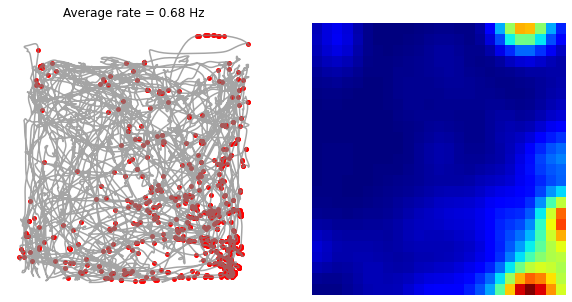

In [82]:
# plot spikes,ratemap
def spike_positions_2d(spike_times,position,pos_times):

    spike_x = np.interp(spike_times,pos_times,position[:,0])
    spike_y = np.interp(spike_times,pos_times,position[:,1])
    return spike_x,spike_y

sorted_idxs = np.argsort(cell_properties.spatial_info_A.values)[::-1]

rank = 8
cell = sorted_idxs[rank]

figure(figsize=(10,5))

subplot(1,2,1)
title(f'Average rate = {cell_properties.avg_rate_A.values[cell]:.2f} Hz')
plot(position[:,0],position[:,1],alpha=0.7,c='gray')
[x,y] = spike_positions_2d(spike_times[cell],position,pos_times)
scatter(x,y,c='r',s=15,alpha=1)
axis('off')
ax = subplot(1,2,2)
sm = ratemaps[cell]
ax.matshow(sm.T,cmap=cm.jet,origin='lower',aspect='auto')

axis('off')